In [ ]:
# Install required packages if not already present
!pip install torch scikit-learn joblib matplotlib pandas onnx

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHo+tEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import joblib


In [ ]:
# Mount drive if needed, then point to your uploaded CSV
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/adm_data.csv'   # adjust if in another folder

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (400, 9)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
# Try to infer the target column automatically
all_cols = df.columns.tolist()
candidate_names = [c for c in all_cols if c.lower().strip() in (
    'target','y','price','admit','admitted','admission','chance of admit',
    'chance','score','gpa')]
if not candidate_names:
    for c in all_cols:
        if any(k in c.lower() for k in ['chance','admit','admission','target','score','y']):
            candidate_names.append(c)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = candidate_names[0] if candidate_names else numeric_cols[-1]
print("Inferred target column:", target_col)

X = df.drop(columns=[target_col])
y = df[target_col].astype(float).values

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_processed = preprocessor.fit_transform(X)
print("Processed feature shape:", X_processed.shape)

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

Inferred target column: Chance of Admit 
Processed feature shape: (400, 8)


In [ ]:
def make_loader(Xa, ya, batch_size=64, shuffle=True):
    tX = torch.tensor(Xa, dtype=torch.float32)
    ty = torch.tensor(ya, dtype=torch.float32).unsqueeze(1)
    ds = TensorDataset(tX, ty)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train)
val_loader   = make_loader(X_val, y_val, shuffle=False)
test_loader  = make_loader(X_test, y_test, shuffle=False)
input_dim = X_processed.shape[1]
print("Input dimension:", input_dim)


Input dimension: 8


In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, 1)
    def forward(self, x):
        return self.lin(x)

class SmallMLP(nn.Module):
    def __init__(self, in_dim, hidden=64, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepMLP(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(h2, 1)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
def train_model(model, train_loader, val_loader, lr=1e-3, weight_decay=0.0,
                epochs=300, patience=20, device='cpu'):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_loss = float('inf')
    best_state = None
    wait = 0
    history = {'train': [], 'val': []}

    for ep in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(loss_fn(model(xb), yb).item())

        train_l, val_l = np.mean(train_losses), np.mean(val_losses)
        history['train'].append(train_l)
        history['val'].append(val_l)

        if val_l < best_loss:
            best_loss = val_l
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(best_state)
    return model, history


In [ ]:
models = {
    'Linear': LinearModel(input_dim),
    'Linear_L2': LinearModel(input_dim),
    'SmallMLP': SmallMLP(input_dim),
    'DeepMLP': DeepMLP(input_dim)
}

results = {}
histories = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for name, m in models.items():
    wd = 1e-2 if name == 'Linear_L2' else 0.0
    print(f"Training {name}...")
    trained, hist = train_model(m, train_loader, val_loader, lr=1e-3,
                                weight_decay=wd, device=device)
    histories[name] = hist

    # Evaluate
    trained.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = trained(xb.to(device))
            y_true.append(yb.numpy())
            y_pred.append(preds.cpu().numpy())
    y_true = np.vstack(y_true).ravel()
    y_pred = np.vstack(y_pred).ravel()

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    results[name] = (r2, mse, trained)
    print(f"{name}: R²={r2:.4f}, MSE={mse:.6f}")

pd.DataFrame([
    {'Model': k, 'R2': v[0], 'MSE': v[1]} for k,v in results.items()
]).sort_values('R2', ascending=False)


Training Linear...
Linear: R²=-0.0689, MSE=0.027601
Training Linear_L2...
Linear_L2: R²=0.7823, MSE=0.005622
Training SmallMLP...
SmallMLP: R²=0.8059, MSE=0.005013
Training DeepMLP...
DeepMLP: R²=0.8349, MSE=0.004263


,Model,R2,MSE
3,DeepMLP,0.834926,0.004263
2,SmallMLP,0.805889,0.005013
1,Linear_L2,0.782295,0.005622
0,Linear,-0.068854,0.027601


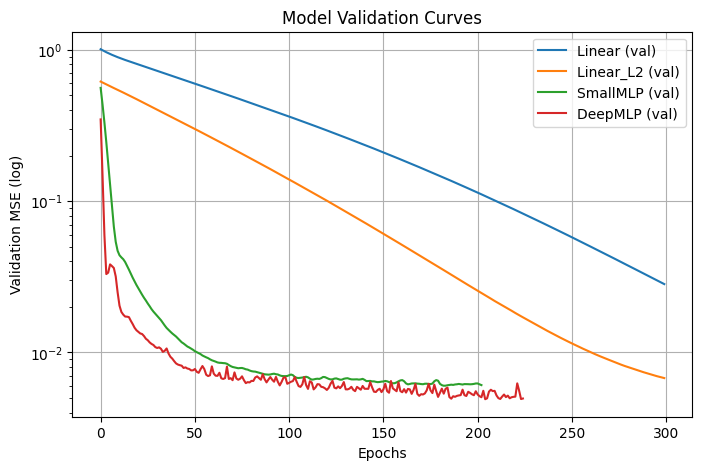

In [ ]:
plt.figure(figsize=(8,5))
for name,h in histories.items():
    plt.plot(h['val'], label=f"{name} (val)")
plt.yscale('log')
plt.xlabel("Epochs"); plt.ylabel("Validation MSE (log)")
plt.legend(); plt.title("Model Validation Curves")
plt.grid(True); plt.show()


In [ ]:
best_name = max(results.items(), key=lambda kv: kv[1][0])[0]
best_model = results[best_name][2]
print(f"Best model: {best_name} | R²={results[best_name][0]:.4f}")

onnx_path = "/content/best_model.onnx"
dummy_input = torch.randn(1, input_dim)
torch.onnx.export(best_model, dummy_input, onnx_path,
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input':{0:'batch_size'},
                                'output':{0:'batch_size'}},
                  opset_version=16)
print("Saved ONNX model to:", onnx_path)

prep_path = "/content/preprocessor.joblib"
joblib.dump(preprocessor, prep_path)
print("Saved preprocessor to:", prep_path)


Best model: DeepMLP | R²=0.8349
Saved ONNX model to: /content/best_model.onnx
Saved preprocessor to: /content/preprocessor.joblib


/tmp/ipython-input-3032306402.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(best_model, dummy_input, onnx_path,


In [ ]:
best_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = best_model(xb)
        y_true.append(yb.numpy())
        y_pred.append(preds.numpy())
y_true = np.vstack(y_true).ravel()
y_pred = np.vstack(y_pred).ravel()

pred_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
pred_df.head(20)


,True,Pred
0,0.68,0.636017
1,0.68,0.749043
2,0.90,0.911555
3,0.79,0.816502
4,0.44,0.508052
5,0.94,0.905585
6,0.43,0.601528
7,0.36,0.458455
8,0.72,0.675483
9,0.85,0.833049


In [ ]:
from google.colab import files

# Download ONNX and preprocessor files
files.download("/content/best_model.onnx")
files.download("/content/preprocessor.joblib")

print("✅ Files are ready for download — check the popup at the bottom-left in Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files are ready for download — check the popup at the bottom-left in Colab.
